In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.decomposition import PCA
import scipy.stats as sps

In [5]:
import SynthData# import Periodic3Noise, FewSig, NoisySig
from algorithms_matrix_profile import *
from utils import *

In [4]:
import imp 
imp.reload(SynthData)
from SynthData import Periodic3Noise, FewSig, NoisySig, ValueOutlier, UnknownSig
from SynthData import MultipleOutliers, MultipleUnknownSig, NoisySigMultipleAno,RepeatedCorrelatedMotifs



In [4]:
#np.random.seed(12)
#data = FewSig(nb_noisy=4, type_anomaly='motif', sigma_noise=0.3)
#data = Periodic3Noise(type_anomaly='one_series_one_ano', nb_noisy=10, sigma_noise=2)
n_samples=400
#data = NoisySig(nb_ano=4, nb_dim=6, where=-1, type_ano='mean', ano_size=20, n_samples=n_samples, other_ano=False)#, different_freq=True, sigma_noise=0.001)
data = MultipleUnknownSig(nb_ano=3,nb_ano_series=3, nb_dim=6, where=-1, type_ano='contextual', n_samples=n_samples, sigma_noise=0.1, ano_size=20, different_freq=False)#, sigma_noise=0.001)



X = data.S
#X = X[0:2]
X.shape
#Y = X[:,1:]-X[:,:-1]
#X = np.zeros((4,20))
#X[0] = np.random.choice(4,20)
#X[1] = np.random.choice(4,20)
#X[2] = np.random.choice(4,20)
#X[3] = np.random.choice(4,20)

(6, 400)

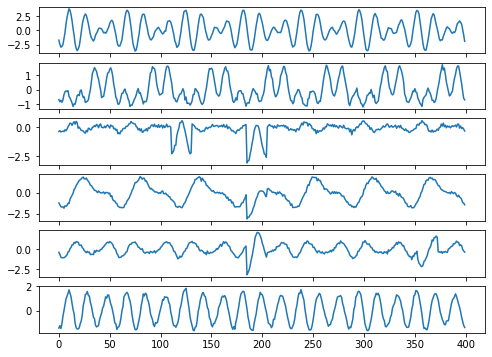

array([185, 111, 353])

In [5]:
#X=Y
plot_series(X)
data.where


###### Normalisation

In [6]:
X = (X-X.mean(axis = 1)[:,None])/X.std(axis = 1)[:,None]

###### Nouvelles données très corrélées 

nb_dim = 6 
n_samples = 2000
where = [300, 1000, 1500]
sigma_noise = 0.1
X=np.zeros((nb_dim, n_samples))
nb_periods = np.random.choice(np.arange(3,11))
x = np.linspace(0, nb_periods*2*np.pi, n_samples)
freq = np.random.choice(5,3)
for i in range(nb_dim):
    coef = (np.random.rand(3)-1) *2
    X[i] = coef[0] * np.sin(freq[0]*x) + coef[1] * np.cos(freq[1]*x) + coef[2]*  np.sin(freq[2]*x)
        
X += sigma_noise*np.random.randn(nb_dim, n_samples)

for i, t in enumerate(where):
    series = np.random.choice(nb_dim, 3, replace=False)#np.random.randint(1,nb_ano_series+1), replace=False)
    a = np.random.choice(2) #choix d'une valeur trop grande ou trop petite
    X[series, t] = a*(np.max(X, axis=1)[series]+0.5*np.abs(np.max(X, axis=1)[series]) ) + (1-a)*(
        np.min(X, axis=1)[series]- 0.5*np.abs(np.min(X, axis=1)[series]))

X = (X-X.mean(axis = 1)[:,None])/X.std(axis = 1)[:,None]
plot_series(X)

### VAR

In [11]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

[ -1.20407973 -20.68028786 -21.76253311 -22.20403402 -22.57363036
 -22.71781219 -22.95599984 -23.25657494 -23.35456874 -23.39590884
 -23.39415567 -23.48404715 -23.5324717  -23.54175861 -23.59661236
 -23.58034304 -23.565996   -23.53543264 -23.53439435 -23.53725731
 -23.56738261 -23.57681119 -23.56688247 -23.56273702 -23.51472218
 -23.4984159  -23.4385419  -23.38738305 -23.30373669 -23.29774809
 -23.32316555 -23.38279544 -23.44995457 -23.55808886 -23.57819696
 -23.64968168 -23.80172581 -23.78179586 -23.85246857 -23.89354987
 -23.98220819 -24.29366099]
[ -1.14420776 -20.26039718 -20.98126865 -21.06003216 -21.06551892
 -20.84421028 -20.71551785 -20.64781443 -20.37612236 -20.04636026
 -19.6720795  -19.38800886 -19.06102752 -18.6934555  -18.36998785
 -17.97392522 -17.57830338 -17.1649741  -16.77966902 -16.3967545
 -16.03958174 -15.66018167 -15.25988361 -14.86381795 -14.42232177
 -14.01096262 -13.55445377 -13.10506751 -12.62159054 -12.21415735
 -11.83650538 -11.49143003 -11.15223707 -10.85236

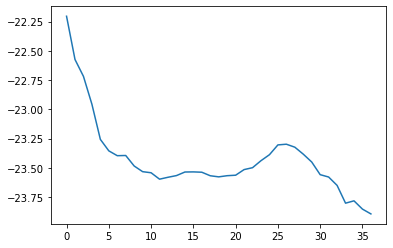

In [13]:
#diff = X_new[:,1:]-X_new[:,:-1]
model = VAR(X.T)
AICs = np.zeros(42)
BICs = np.zeros(42)
FPEs = np.zeros(42)
HQICs = np.zeros(42)
for i in np.arange(0,42):
    result = model.fit(i)
    AICs[i] = result.aic
    BICs[i] = result.bic
    FPEs[i] = result.fpe
    HQICs[i] = result.hqic
print( AICs)
print(BICs)
print(FPEs)
print(HQICs)
plt.plot(AICs[3:40])

In [14]:
model = VAR(X.T)
start = time.time()
results = model.fit(10)
results.summary()
duree = time.time()-start
print('duree =', duree, 's')

duree = 0.13961386680603027 s


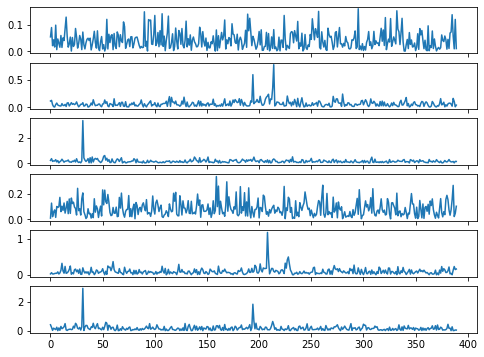

In [15]:
plot_series(np.abs(results.resid.T))


In [16]:
new_resid = np.mean(np.abs(results.resid.T), axis = 0)

[218 204  41]


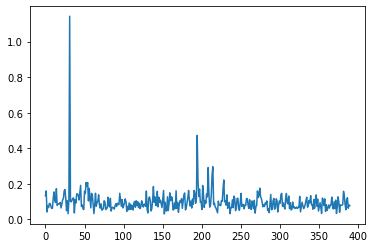

In [17]:
plt.plot(new_resid)
print(data.where)

In [18]:
threshold = 0.7
np.where(new_resid>threshold)

(array([31]),)

### PCA + AR

##### PCA

In [19]:
pca = PCA(n_components=0.95,whiten=True, svd_solver='full')
pca.fit(X.T)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)
print(pca.components_)
X_new = pca.transform(X.T).T

[0.38241011 0.17274912 0.16072195 0.14943252 0.09189029]
[30.29495428 20.36167673 19.64007855 18.93774138 14.85047776]
[[-0.31065709 -0.10289651 -0.48575085 -0.59903821 -0.04714708 -0.54394941]
 [-0.24193604  0.57926496  0.09916494 -0.0918689   0.76616627 -0.02519383]
 [ 0.23219182  0.8028582  -0.10493447 -0.05643166 -0.52959092 -0.08272451]
 [ 0.83163483 -0.06831789 -0.4076619  -0.04311309  0.35917105 -0.08164168]
 [ 0.26236295 -0.05688618  0.69096526 -0.08207169  0.00467955 -0.66613737]]


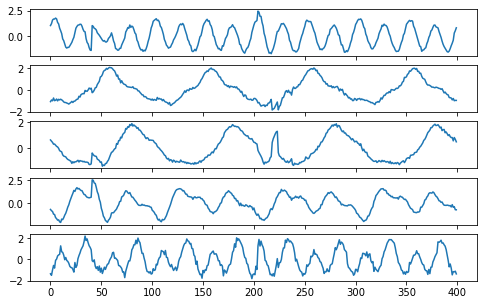

In [20]:
plot_series(X_new)

###### Reconstruction 

In [21]:
X_reconstr = pca.inverse_transform(X_new.T).T
#plot_series (X_reconstr)


array([218, 204,  41])

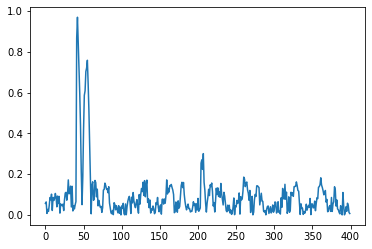

In [22]:
#plot_series(X_reconstr-X)
plt.plot(np.mean(np.abs(X_reconstr-X), axis = 0))
data.where

Deja juste la PCA+reconstruction ça a un effet important sur ce genre d'anomalies.

##### AR

In [23]:
from statsmodels.tsa.stattools import acf, adfuller, kpss, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

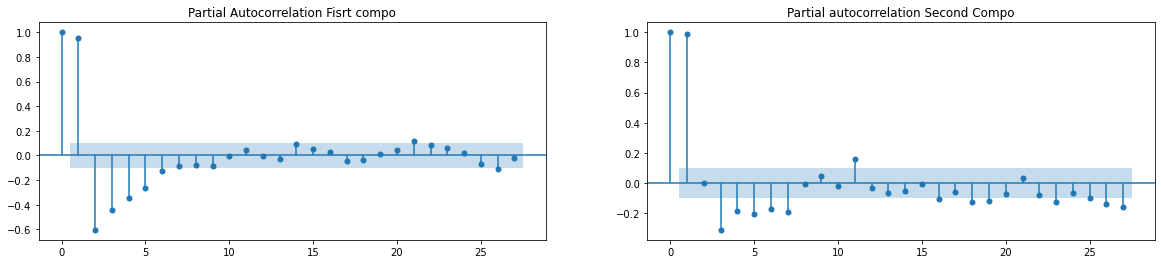

In [24]:
fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize=(20, 4))
_ = plot_pacf(X_new[0], ax=ax_0, title="Partial Autocorrelation Fisrt compo")
_ = plot_pacf(X_new[1], ax=ax_1, title="Partial autocorrelation Second Compo")

/Users/rc/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


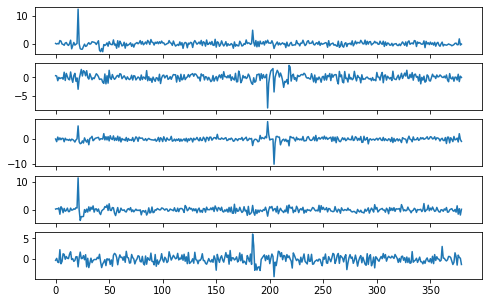

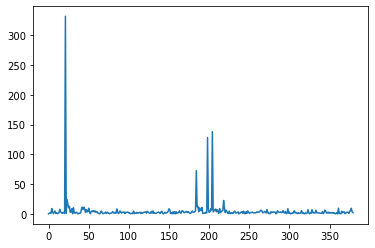

In [25]:
k, _= X_new.shape
order = 20
s = []
resids = np.zeros((k,n_samples - order))
fittedvalues = np.zeros((k, n_samples - order))
for i in range(k):
    s.append(AutoReg(X_new[i], lags=order).fit())
    resids[i] = s[i].resid
    fittedvalues[i] = s[i].fittedvalues
#s0 = AutoReg(X_new[0], lags=15).fit()
#s1 = AutoReg(X_new[1], lags=15).fit()
resids = (resids-resids.mean(axis = 1)[:,None])/resids.std(axis = 1)[:,None]
plot_series(resids)
plt.plot(np.sum(resids**2, axis = 0))


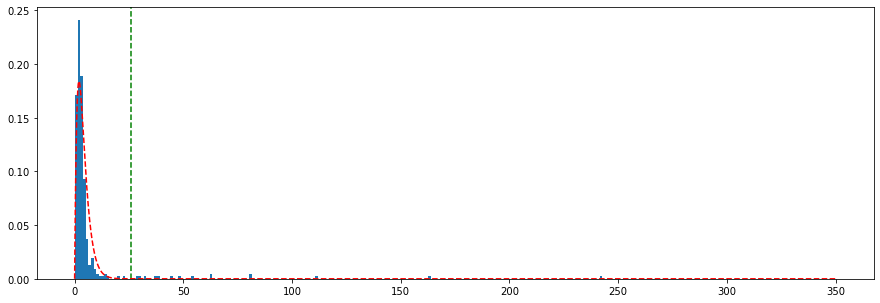

In [59]:
chi = np.sum(resids**2, axis = 0)
thresh = sps.chi2.ppf(0.9999, df=k)


quantile_threshold_low, quantile_threshold_high = 0.015, 0.995

fig, ax = plt.subplots(figsize=(15,5))
_ = ax.hist(chi, 200, density=True)

threshold_low, threshold_high = np.quantile(
    chi, [quantile_threshold_low, quantile_threshold_high]
)
_ = ax.axvline(thresh, ls="--", color="g")
#_ = ax.axvline(threshold_low, ls="--", color="k")
#_ = ax.axvline(threshold_high, ls="--", color="k")
ax.plot(np.linspace(0,350,10000), sps.chi2.pdf(x=np.linspace(0,350,10000),df = k-1),'r--')



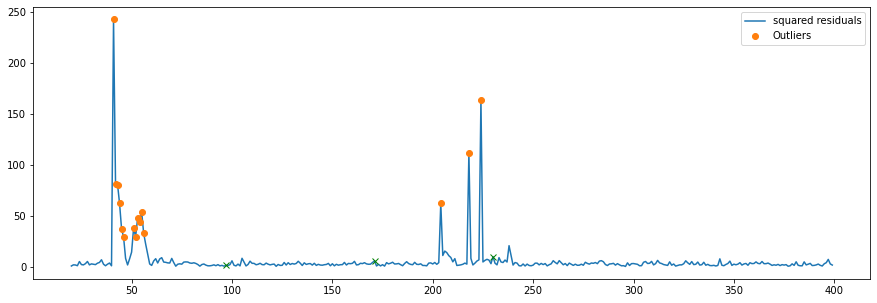

In [60]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(
    np.arange(order, order+chi.size),chi, label="squared residuals"
)
threshold_low=thresh
outlier_mask = (chi > thresh)

ax.plot(
    np.arange(order,order+chi.size)[outlier_mask],
    chi[outlier_mask],
    "o",
    label="Outliers",
)
ax.plot(data.where,chi[data.where-order],'gx')
plt.legend()

In [28]:
print(np.where(chi > thresh))

(array([ 21, 184, 198, 204]),)


In [29]:
print(data.where)
print(np.mean(np.abs(resids), axis = 0).argmax() + order)

[218 204  41]
41


__Reconstruction of the full signal before residuals__

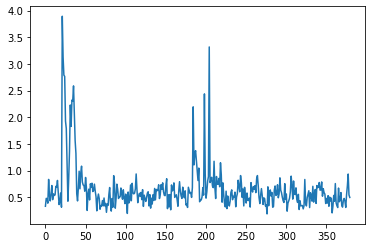

In [30]:
#newPCA = np.c_[s0.fittedvalues, s1.fittedvalues].shape
X_reconstr = pca.inverse_transform(fittedvalues.T).T
#plot_series (X_reconstr)
resids = X_reconstr-X[:,order:]
resids = (resids-resids.mean(axis = 1)[:,None])/resids.std(axis = 1)[:,None]
#plot_series(resids)
plt.plot(np.mean(np.abs(resids), axis = 0))

In [31]:
threshold = 1.2
print(np.where(np.mean(np.abs(resids), axis = 0)>threshold))
data.where - order

(array([ 21,  22,  23,  24,  25,  26,  30,  31,  32,  33,  34,  35,  36,
        37,  38, 184, 186, 187, 198, 204]),)


array([198, 184,  21])

### SPIRIT

d, n = X.shape 
ks = np.zeros(n)  #nombre de dimensions considees a chaque pas 
k = 1            # nb de dimesions actuel   
lbd = 1           
w = np.zeros((n, d, d))   #poids: pour chaque t(dans [1,n]), liste des vect w  
w[0,0,0]=1          # initialisation de w comme dans l'article 
E = 0           # energie totale init a 0
E_tilde = np.zeros(d)   #energie estimée, init a 0 pour chaque dim 
di = 0.01 * np.ones(d)  #pas compris à quoi ça sert...
e = np.zeros((d,d))   #erreur (residus)
f = 0.95       #bornes pour l'energie 
F = 0.98
y = np.zeros((n, d))  #projsur les vecteurs w (en chaque t, nv coord)
pb=0         #nb de fois ou on veut augmenter k mais pas possible
pb = np.zeros(n)
for t in range(n) : #attention entre t et t+1 article
    if t!=0 : 
        w[t] = w[t-1]
    x = X[:,t]
    x_ = x.copy()
    E = (t*E + np.dot(x,x) ) / (t+1) 
    for i in range(k):
        y[t,i] = np.dot(w[t,i], x_)
        di[i] = lbd * di[i] + y[t,i]**2
        e[i] = x_ - y[t,i]*w[t,i]
        w[t,i] = w[t,i] + 1/di[i] * y[t,i] * e[i]
        x_ = x_ - y[t,i]*w[t,i]
        E_tilde[i] = (t*E_tilde[i] + y[t,i]**2)/(t+1)
    E_k = np.sum(E_tilde)
    if E_k > F*E : 
        k = k-1
        w[t,k] = np.zeros(d)
        E_tilde[k] = 0
        di[k] = 0.01
    elif E_k < f * E : 
        if k!=d:
            w[t, k, k] = 1
            y[t,k] = np.dot(w[t,k], x_)
            di[k] = lbd * di[k] + y[t,k]**2
            e[k] = x_ - y[t,k]*w[t,k]
            w[t,k] = w[t,k] + 1/di[k] * y[t,k] * e[k]
            E_tilde[k] = y[t,k]**2/(t+1)
            k = k+1
        if k==d : 
            #pb +=1
            pb[t]=1
    ks[t] = k

In [32]:
d, n = X.shape 
ks = np.zeros(n)  #nombre de dimensions considees a chaque pas 
k = 1            # nb de dimensions actuel   
lbd = 1           
w = np.zeros((n, d, d))   #poids: pour chaque t(dans [1,n]), liste des vect w  
w[0,0,0]=1          # initialisation de w comme dans l'article 
E = 0           # energie totale init a 0
E_tilde = np.zeros(d)   #energie estimée, init a 0 pour chaque dim 
di = 0.5 * np.ones(d)  #pas compris à quoi ça sert...
e = np.zeros((d,d))   #erreur (residus)
f = 0.95       #bornes pour l'energie 
F = 0.98
y = np.zeros((n, d))  #projsur les vecteurs w (en chaque t, nv coord)
pb=0         #nb de fois ou on veut augmenter k mais pas possible
pb = np.zeros(n)
for t in range(n) : #attention entre t et t+1 article
    if t!=0 : 
        w[t] = w[t-1]
    x = X[:,t]
    x_ = x.copy()
    E = (t*E + np.dot(x,x) ) / (t+1) 
    for i in range(k):
        y[t,i] = np.dot(w[t,i], x_)
        di[i] = lbd * di[i] + y[t,i]**2
        e[i] = x_ - y[t,i]*w[t,i]
        w[t,i] = w[t,i] + 1/di[i] * y[t,i] * e[i]
        x_ = x_ - y[t,i]*w[t,i]
        E_tilde[i] = (t*E_tilde[i] + y[t,i]**2)/(t+1)
    E_k = np.sum(E_tilde)
    if E_k > F*E : 
        k = k-1
        w[t,k] = np.zeros(d)
        E_tilde[k] = 0
        di[k] = 0.5
    elif E_k < f * E : 
        if k!=d:
            w[t, k, k] = 1
            y[t,k] = np.dot(w[t,k], x_)
            di[k] = lbd * di[k] + y[t,k]**2
            e[k] = x_ - y[t,k]*w[t,k]
            w[t,k] = w[t,k] + 1/di[k] * y[t,k] * e[k]
            E_tilde[k] = y[t,k]**2
            k = k+1
        if k==d : 
            #pb +=1
            pb[t]=1
    ks[t] = k

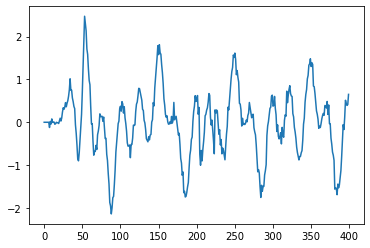

In [33]:
plt.plot(y[:,4])

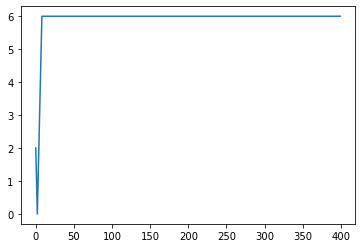

In [34]:
plt.plot(ks)

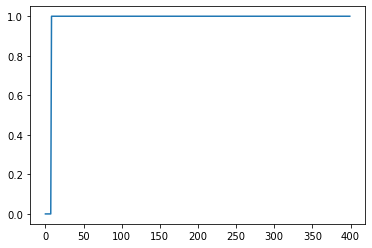

392.0


In [35]:
plt.plot(pb)
plt.show()
print(pb.sum())

##### Reconstruction de x ?

In [36]:
X_rec = np.zeros((n,d))
for t in range(n):
    for i in range(int(ks[t])):
        X_rec[t]+= y[t,i]*w[t,i]
X_rec = X_rec.T

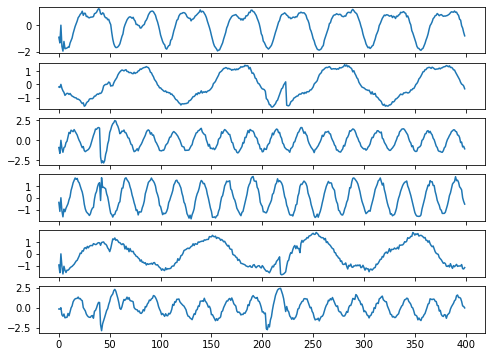

In [37]:
plot_series(X_rec)

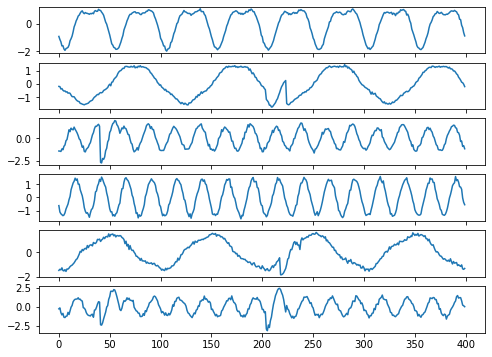

In [38]:
plot_series(X)

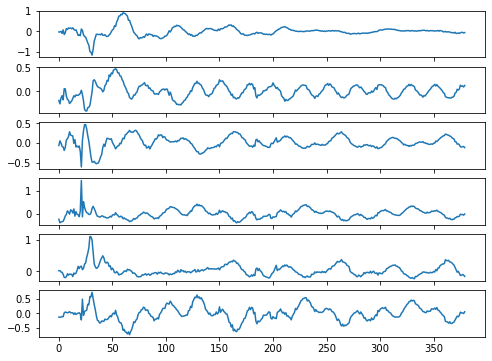

In [39]:
diff = X-X_rec
plot_series(np.where(np.abs(diff)<1e-5, 0, diff)[:,20:])

In [40]:
res = AutoReg(y[:,2], lags=order).fit().resid

/Users/rc/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


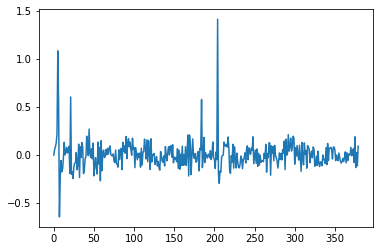

In [44]:
plt.plot(res)

In [43]:
np.abs(res).argmax()

204

In [37]:
data.where

array([131243])

### Automatisation

In [13]:
import PCA_AR
imp.reload(PCA_AR)

from PCA_AR import *

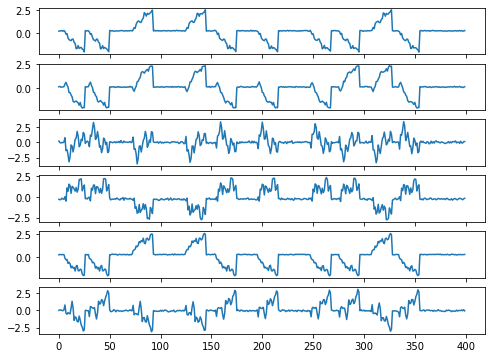

In [14]:
n_samples=400
data = RepeatedCorrelatedMotifs(nb_ano=3,nb_ano_series=3, nb_dim=6, where=-1, type_ano='global', n_samples=n_samples, sigma_noise=0.1, ano_size=20, different_freq=False)#, sigma_noise=0.001)

X = data.S
X = (X-X.mean(axis = 1)[:,None])/X.std(axis = 1)[:,None]
plot_series(X)

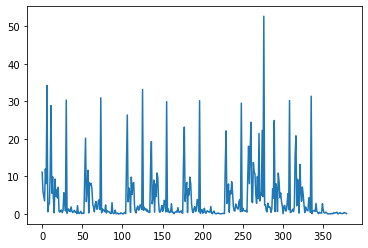

In [15]:
square_res, k = sum_square_resids_PCA_AR(X, 0.95, 20)
plt.plot(square_res)

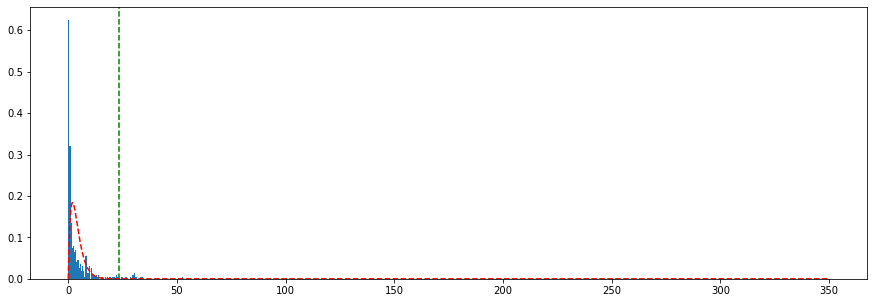

In [16]:
plot_hist_resids_chi2(square_res, k)

In [17]:
ano = all_anomalous_points(square_res, k, quantile = 0.5 )
print(ano)

[ 20  21  22  23  24  25  26  30  31  32  33  34  36  37  38  39  40  47
  48  50  73  74  76  77  79  80  81  82  90  91  93 125 126 128 129 131
 132 133 134 145 155 156 158 159 161 162 163 164 172 173 175 196 197 198
 199 200 202 203 204 205 213 214 216 248 249 251 252 254 255 256 257 266
 268 276 277 278 279 280 283 284 285 286 288 289 290 291 292 293 294 295
 296 307 308 309 311 312 314 315 316 317 326 328 335 336 338 339 341 342
 343 344 345 352 353 355]


In [18]:
data.where

array([276, 276,   6])

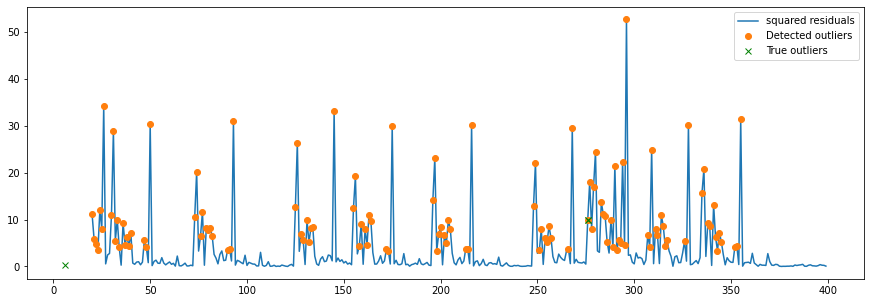

In [19]:
plot_anomalous_points(square_res,ano, data.where, order=20)

In [148]:
anos = find_anomalies(X, 0.95, 20, 0.9999)

In [149]:
anos

array([239, 265, 308, 328])

In [151]:
anos, sc = find_anomalies_order(X, 0.95, 20, 0.3)

In [152]:
anos

array([308, 265, 239, 330, 286, 376,  98, 205,  58, 161, 398, 123, 183,
        26, 351])

In [153]:
sc

array([1.        , 1.        , 1.        , 0.99999936, 0.9998679 ,
       0.94522378, 0.89420978, 0.87170184, 0.84276764, 0.83828536,
       0.74113469, 0.71623353, 0.69802954, 0.67254675, 0.52326322])

In [154]:
data.where

array([308, 239, 265])

### Evaluation
#### Courbes recall/precision

In [177]:
n_iter = 100
order=20
var = 0.95
correct = 0
l = 20 #anomaly size
n_samples=400
nb_dim=6 
nb_ano_series=3
#start = time.time()
np.random.seed(500)
type_data = [MultipleOutliers,MultipleOutliers,MultipleOutliers,MultipleOutliers, MultipleUnknownSig,
             MultipleUnknownSig, NoisySigMultipleAno, NoisySigMultipleAno, NoisySigMultipleAno, NoisySigMultipleAno]
type_data_names = ['MultipleOutliers','MultipleOutliers','MultipleOutliers','MultipleOutliers', 'MultipleUnknownSig',
             'MultipleUnknownSig', 'NoisySigMultipleAno', 'NoisySigMultipleAno', 'NoisySigMultipleAno','NoisySigMultipleAno']
type_ano = ['global', 'contextual', 'global', 'contextual', '', '', 'variance_big','variance_small', 'type' ,'mean']    
diff_freq = [False, False,True, True, False,True, False, False, False, False]
results = np.zeros((len(type_data),100, 3))
for idx, fct in enumerate(type_data):    
    print(idx)
    sum_scores =np.zeros(5)
    start = time.time()
    recalls = np.zeros(n_iter)
    precisions = np.zeros(n_iter)
    #results = np.zeros((100, 3))
    for j in range(n_iter):
        sys.stdout.write('\r'+str((100*j)//n_iter)+'%')
        sys.stdout.flush()
        data = fct(nb_ano=-1,nb_ano_series=nb_ano_series, nb_dim=nb_dim, where=-1, type_ano=type_ano[idx],
                   ano_size=l, n_samples=n_samples, different_freq=diff_freq[idx])
        X=data.S
        ano_list, ano_score = find_anomalies_order(X, var, order, quantile=0.2)

        for i, thresh in enumerate(np.linspace(0.999,0.99999, 100)):
            TP, FN, FP,_,_ = score(ano_list[ano_score>thresh], data.where, data.ano_size, order)
            results[idx,i, 0] += TP
            results[idx,i, 1] += FN
            results[idx,i, 2] += FP

    exec_time = time.time()-start

    sys.stdout.write('\r100%  -- Execution time = '+str(round(exec_time,2))+'s\n')

filename = 'PCA+AR_ROC_nocenter_nsamples='+ str(n_samples)+'_nbdim=' + str(nb_dim)+'_nbanoseries='+str(nb_ano_series)+'.npz'
np.savez(filename, rates = results, params = np.array([type_data_names, type_ano, diff_freq]))



0
100%  -- Execution time = 2.39s
1
95%

KeyboardInterrupt: 

In [168]:
precision = np.where((results[:,:,0]+results[:,:,2])!=0,results[:,:,0]/(results[:,:,0]+results[:,:,2]), 1)
recall = np.where((results[:,:,0]+results[:,:,1])!=0,results[:,:,0]/(results[:,:,0]+results[:,:,1]), 1)
F1 = np.where( precision + recall !=0 ,2*precision*recall/(precision+recall), 0 )

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


No handles with labels found to put in legend.


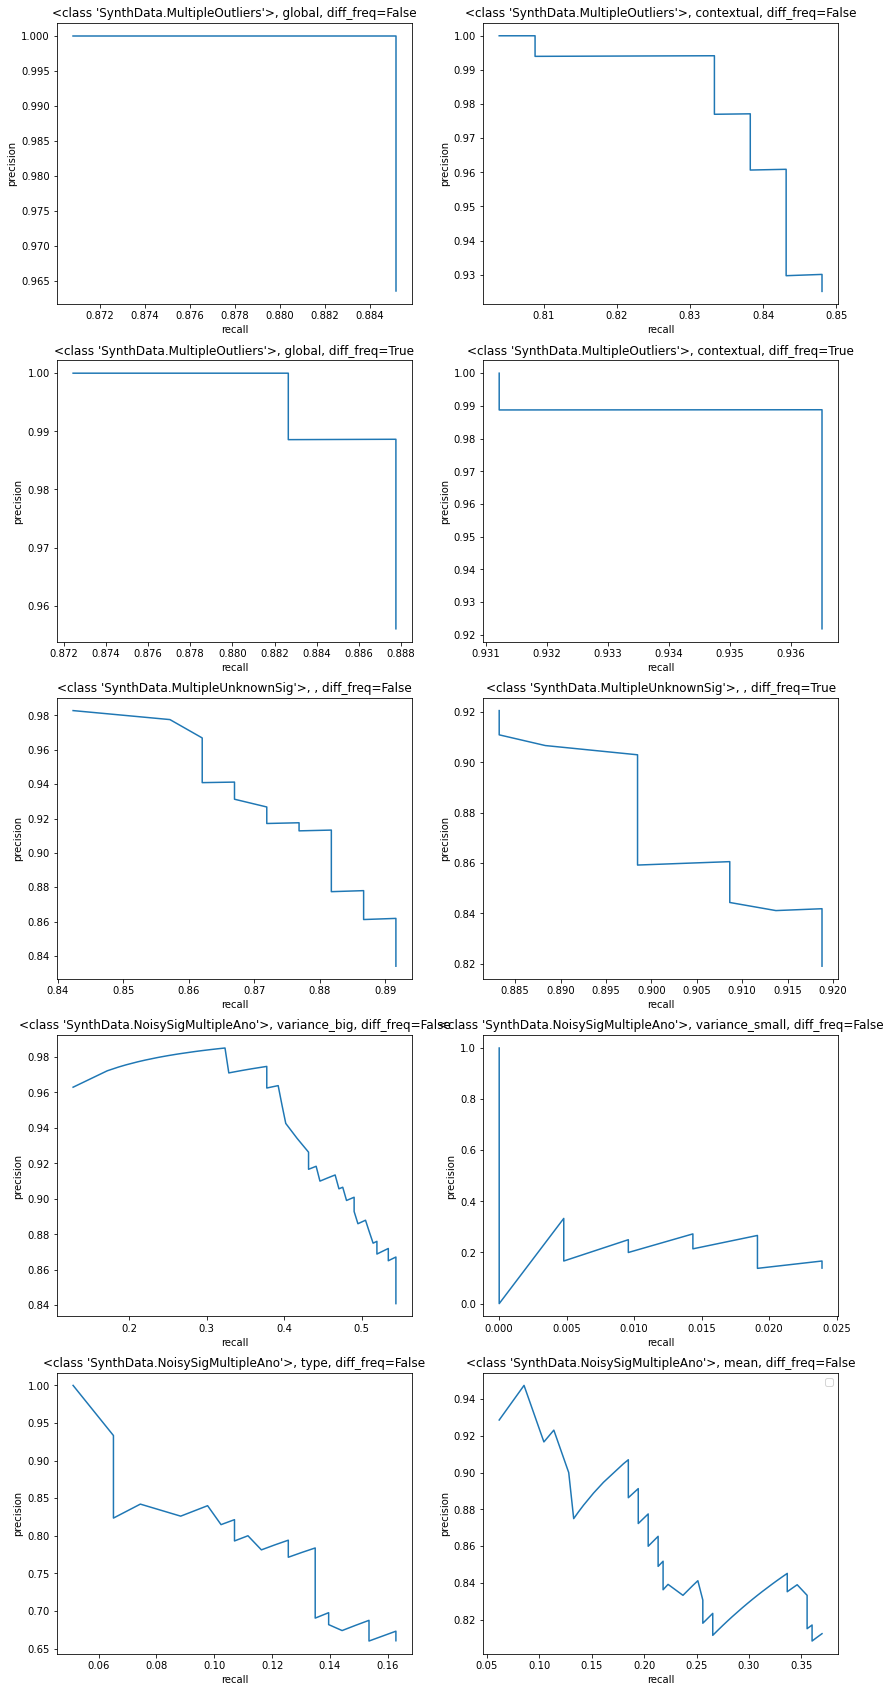

In [169]:
#plt.plot(recall, precision)
#plt.xlabel('recall')
#plt.ylabel('precision')
#plt.show()
plt.figure(figsize=(14, 30))
for j in range(recall.shape[0]):
    plt.subplot(5, 2, j + 1)
    plt.plot(recall[j],precision[j])
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title(str(type_data[j])+', '+ str(type_ano[j])+', diff_freq='+str(diff_freq[j]))
plt.legend()
plt.show()

In [170]:
print(recall[1])

[0.84803922 0.84803922 0.84803922 0.84313725 0.84313725 0.84313725
 0.84313725 0.84313725 0.84313725 0.84313725 0.84313725 0.84313725
 0.84313725 0.84313725 0.84313725 0.84313725 0.84313725 0.84313725
 0.84313725 0.84313725 0.84313725 0.84313725 0.84313725 0.84313725
 0.84313725 0.84313725 0.84313725 0.84313725 0.84313725 0.84313725
 0.84313725 0.84313725 0.84313725 0.84313725 0.84313725 0.84313725
 0.84313725 0.84313725 0.84313725 0.84313725 0.84313725 0.84313725
 0.84313725 0.83823529 0.83823529 0.83823529 0.83823529 0.83823529
 0.83823529 0.83823529 0.83823529 0.83823529 0.83823529 0.83823529
 0.83823529 0.83823529 0.83823529 0.83823529 0.83823529 0.83823529
 0.83823529 0.83823529 0.83823529 0.83823529 0.83333333 0.83333333
 0.83333333 0.83333333 0.83333333 0.83333333 0.83333333 0.83333333
 0.83333333 0.83333333 0.83333333 0.83333333 0.83333333 0.83333333
 0.83333333 0.83333333 0.83333333 0.83333333 0.83333333 0.83333333
 0.82843137 0.82843137 0.82843137 0.82843137 0.82843137 0.8284

In [171]:
print(precision[1])

[0.92513369 0.93010753 0.93010753 0.92972973 0.92972973 0.92972973
 0.92972973 0.92972973 0.92972973 0.92972973 0.92972973 0.93478261
 0.93478261 0.93478261 0.93989071 0.93989071 0.93989071 0.93989071
 0.93989071 0.94505495 0.94505495 0.94505495 0.94505495 0.95027624
 0.95027624 0.95027624 0.95027624 0.95027624 0.95027624 0.95027624
 0.95027624 0.95027624 0.95027624 0.95027624 0.95027624 0.95555556
 0.96089385 0.96089385 0.96089385 0.96089385 0.96089385 0.96089385
 0.96089385 0.96067416 0.96067416 0.96067416 0.96067416 0.96067416
 0.96067416 0.96067416 0.96610169 0.96610169 0.96610169 0.97159091
 0.97159091 0.97159091 0.97159091 0.97159091 0.97714286 0.97714286
 0.97714286 0.97714286 0.97714286 0.97714286 0.97701149 0.97701149
 0.97701149 0.97701149 0.97701149 0.97701149 0.97701149 0.98837209
 0.98837209 0.98837209 0.98837209 0.98837209 0.98837209 0.98837209
 0.99415205 0.99415205 0.99415205 0.99415205 0.99415205 0.99415205
 0.99411765 0.99411765 0.99411765 0.99411765 0.99411765 0.9941

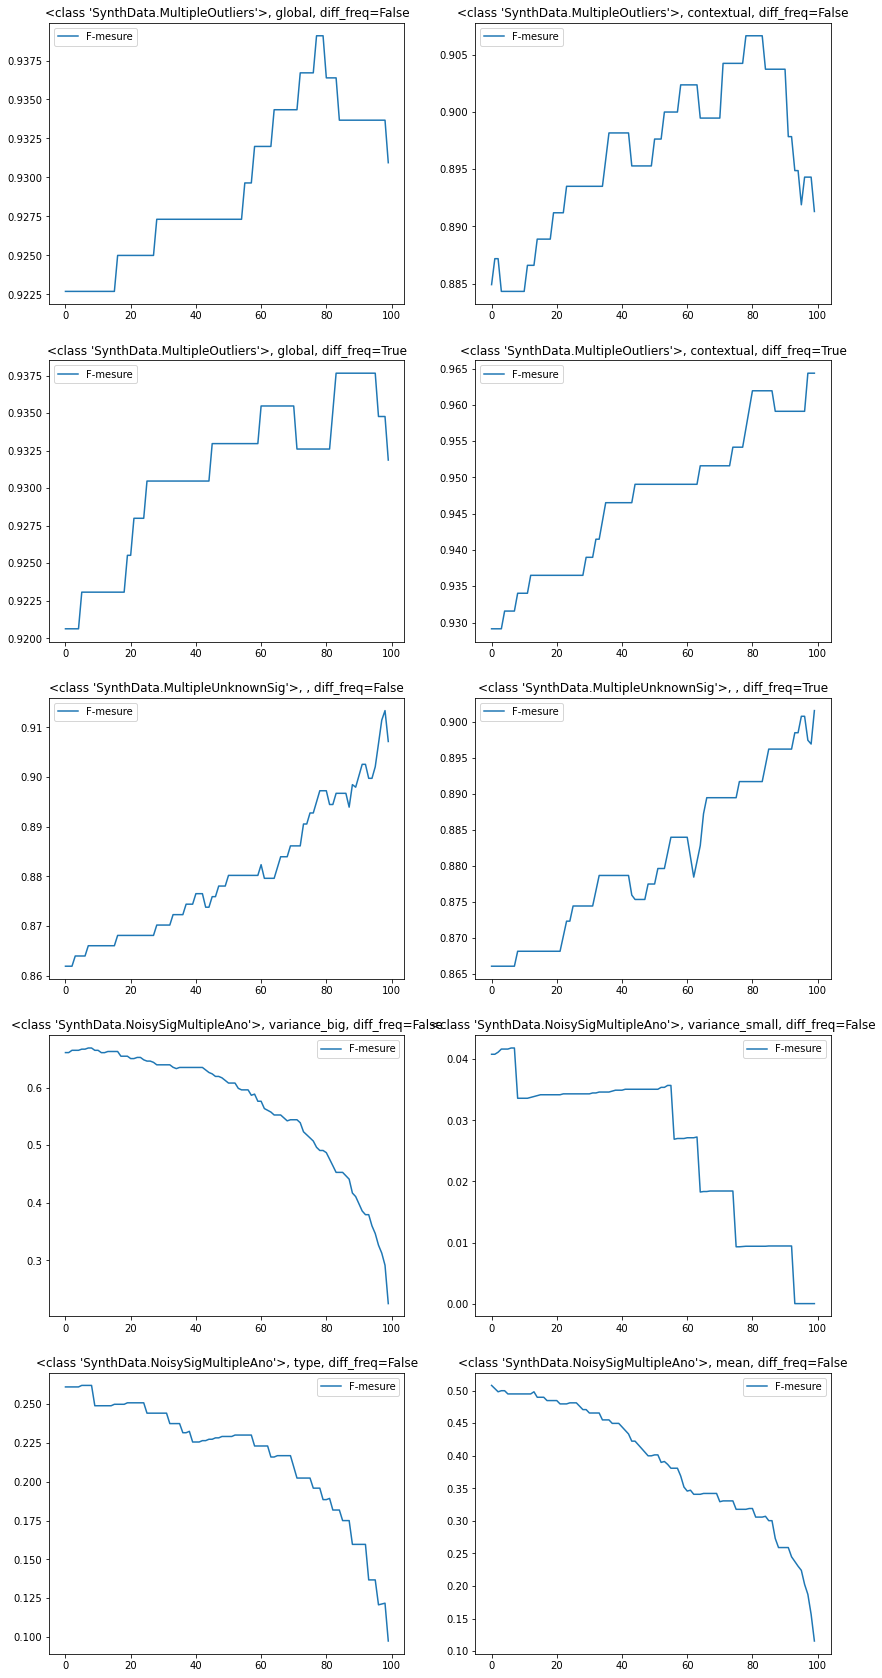

[77 78 83 97 98 99  7  6  5  0]
[0.93908629 0.90666667 0.93766938 0.96438356 0.91338583 0.9015544
 0.6686747  0.041841   0.26217228 0.50814332]
88.66666666666667


In [172]:
plt.figure(figsize=(14, 30))
best_thresh = np.zeros(recall.shape[0], np.uint32)
best_values = np.zeros(recall.shape[0])
for j in range(recall.shape[0]):
    plt.subplot(5, 2, j + 1)
    plt.plot(F1[j], label = 'F-mesure')
    best_thresh[j] = np.argmax(F1[j])
    best_values[j] = np.max(F1[j])
    plt.title(str(type_data[j])+', '+ str(type_ano[j])+', diff_freq='+str(diff_freq[j]))
    plt.legend()
plt.show()
print(best_thresh)
print(best_values)
print(np.mean(best_thresh[best_values>0.8]))

In [173]:
F1[0]


array([0.92269327, 0.92269327, 0.92269327, 0.92269327, 0.92269327,
       0.92269327, 0.92269327, 0.92269327, 0.92269327, 0.92269327,
       0.92269327, 0.92269327, 0.92269327, 0.92269327, 0.92269327,
       0.92269327, 0.925     , 0.925     , 0.925     , 0.925     ,
       0.925     , 0.925     , 0.925     , 0.925     , 0.925     ,
       0.925     , 0.925     , 0.925     , 0.9273183 , 0.9273183 ,
       0.9273183 , 0.9273183 , 0.9273183 , 0.9273183 , 0.9273183 ,
       0.9273183 , 0.9273183 , 0.9273183 , 0.9273183 , 0.9273183 ,
       0.9273183 , 0.9273183 , 0.9273183 , 0.9273183 , 0.9273183 ,
       0.9273183 , 0.9273183 , 0.9273183 , 0.9273183 , 0.9273183 ,
       0.9273183 , 0.9273183 , 0.9273183 , 0.9273183 , 0.9273183 ,
       0.92964824, 0.92964824, 0.92964824, 0.93198992, 0.93198992,
       0.93198992, 0.93198992, 0.93198992, 0.93198992, 0.93434343,
       0.93434343, 0.93434343, 0.93434343, 0.93434343, 0.93434343,
       0.93434343, 0.93434343, 0.93670886, 0.93670886, 0.93670

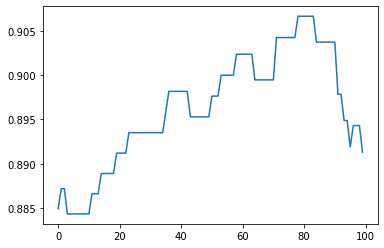

In [174]:
plt.plot(F1[1])

In [175]:
np.argmax(F1[1])

78

#### Benchmark 

In [20]:
from PCA_AR import *
n_iter = 300
m=20
correct = 0
l = 20 #anomaly size
n_samples=400
nb_dim=6 
nb_ano_series=3
var = 0.95
#start = time.time()
rng_data = np.random.RandomState(1) 

type_data = [MultipleOutliers,MultipleOutliers,MultipleOutliers,MultipleOutliers, MultipleUnknownSig,
             MultipleUnknownSig, NoisySigMultipleAno, NoisySigMultipleAno, NoisySigMultipleAno,
             NoisySigMultipleAno, RepeatedCorrelatedMotifs]
type_data_names = ['MultipleOutliers','MultipleOutliers','MultipleOutliers','MultipleOutliers', 'MultipleUnknownSig',
             'MultipleUnknownSig', 'NoisySigMultipleAno', 'NoisySigMultipleAno', 'NoisySigMultipleAno',
                   'NoisySigMultipleAno', 'RepeatedCorrelatedMotifs']
type_ano = ['global', 'contextual', 'global', 'contextual', '', '', 'variance_big','variance_small', 'type' ,
            'mean', '']    
diff_freq = [False, False,True, True, False,True, False, False, False, False, False]
results = pd.DataFrame( {'type_data' : type_data,
                         'type_ano' : type_ano, 
                         'diff_freq' : diff_freq,
                         'n_iter' : [n_iter]*len(type_ano),
                         'n_samples' : [n_samples]*len(type_ano),
                         'nb_ano' : [-1]*len(type_ano),
                         'nb_ano_series' : [nb_ano_series]*len(type_ano),
                         'nb_dim' : [nb_dim]*len(type_ano), 
                         'ano_size' : [l]*len(type_ano),
                         'm': [m]*len(type_ano),
                         'recall' : [0]*len(type_ano),
                         'precision' : [0]*len(type_ano),
                         'mean_recall' : [0]*len(type_ano), 
                         'std_recall' : [0]*len(type_ano),
                         'mean_precision' : [0]*len(type_ano), 
                         'std_precision' : [0]*len(type_ano),
                         'time' :[0]*len(type_ano)})
    

history = np.zeros((len(type_data), n_iter, 3))
for i, fct in enumerate(type_data):    
    sum_scores =np.zeros(5)
    start = time.time()
    np.random.seed(1)
    for j in range(n_iter):
        sys.stdout.write('\r'+str((100*j)//n_iter)+'%')
        sys.stdout.flush()
        data = fct(nb_ano=-1,nb_ano_series=nb_ano_series, nb_dim=nb_dim, where=-1, 
                   type_ano=type_ano[i], ano_size=l, n_samples=n_samples, different_freq=diff_freq[i], rng= rng_data)
        X=data.S
        detected_ano,_ = find_anomalies_order(X, var, m, quantile=0.9998)
        sc = score(detected_ano, data.where, m)
        sum_scores = sum_scores + sc
        history[i,j,0] = sc[3]
        history[i,j,1] = sc[4]
        history[i,j,2] = 2 * (sc[3] * sc[4]) / (sc[3] + sc[4])
        
    exec_time = time.time()-start
    sum_TP,sum_FN,sum_FP,sum_recall,sum_precision = sum_scores
    total_recall = sum_TP/(sum_TP+sum_FN)
    total_precision = sum_TP/(sum_TP+sum_FP)
    sys.stdout.write('\r100%  -- Execution time = '+str(round(exec_time,2))+'s \nmean precision ='+
                     str(sum_precision/n_iter)+ '+-'+str(np.std(history[i,:,1]))+ '-- mean recall ='+
                     str(sum_recall/n_iter) + '+-'+str(np.std(history[i,:,0]))+
                     '\ntotal precision = '+str(total_precision) + '-- total recall = '+str(total_recall)+'\n') 
    results.loc[i,['recall','precision','mean_recall','std_recall','mean_precision','std_precision', 'time' ]] = [
        total_recall,total_precision, sum_recall/n_iter,np.std(history[i,:,0]) ,sum_precision/n_iter, np.std(history[i,:,1]) ,exec_time]


ref = int(time.time()/100)
filename = 'PCA+AR_benchmark_nsamples='+ str(n_samples)+'_nbdim=' + str(nb_dim)+'_nbanoseries='+str(nb_ano_series)+str(ref)
np.savez(filename+'.npz', rates = history, params = np.array([type_data_names, type_ano, diff_freq]))
results.to_csv(filename + '.csv')


24%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


100%  -- Execution time = 10.39s 
mean precision =0.880888888888889+-0.29942467467206024-- mean recall =0.951111111111111+-0.14439742824562568
total precision = 0.8806451612903226-- total recall = 0.931740614334471
26%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


64%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


81%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


98%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


100%  -- Execution time = 10.07s 
mean precision =0.8757777777777779+-0.30085425699267954-- mean recall =0.9247222222222221+-0.2035675260308505
total precision = 0.8631239935587761-- total recall = 0.9084745762711864
100%  -- Execution time = 10.61s 
mean precision =0.9165317460317461+-0.2532923807999913-- mean recall =0.9497222222222221+-0.1348693354855765
total precision = 0.9136577708006279-- total recall = 0.9312
100%  -- Execution time = 10.22s 
mean precision =0.9022777777777776+-0.2594213587159405-- mean recall =0.9413888888888889+-0.1552027248551685
total precision = 0.8835616438356164-- total recall = 0.9148936170212766
7%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


18%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


23%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


27%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


37%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


52%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


55%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


61%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


64%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


70%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


79%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


85%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


95%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


100%  -- Execution time = 10.98s 
mean precision =0.6485+-0.3462317918731665-- mean recall =0.7036111111111111+-0.3205188453849689
total precision = 0.584518167456556-- total recall = 0.6197654941373534
0%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


5%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


16%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


26%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


29%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


30%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


35%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


38%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


47%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


52%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


56%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


60%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


67%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


74%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


76%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


79%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


82%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


85%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


91%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


93%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


95%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


100%  -- Execution time = 11.57s 
mean precision =0.6183968253968252+-0.3531158570724331-- mean recall =0.6891666666666668+-0.34517608227943286
total precision = 0.576036866359447-- total recall = 0.6177924217462932
29%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


62%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


68%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


100%  -- Execution time = 16.48s 
mean precision =0.9788888888888888+-0.12880744553282375-- mean recall =0.5011111111111111+-0.3858596303333476
total precision = 0.9634146341463414-- total recall = 0.38287560581583197
3%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


7%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


9%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


26%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


33%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


51%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


62%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


75%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


78%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


84%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


90%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


100%  -- Execution time = 12.76s 
mean precision =0.9433333333333334+-0.2312045751181311-- mean recall =0.21944444444444444+-0.41145818682604046
total precision = 0.14285714285714285-- total recall = 0.0054249547920434
13%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


21%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


28%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


39%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


60%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


64%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


71%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


82%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


87%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


100%  -- Execution time = 11.24s 
mean precision =0.9372222222222223+-0.23929616445105772-- mean recall =0.29+-0.41036569057366384
total precision = 0.7529411764705882-- total recall = 0.10457516339869281
8%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


11%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


20%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


28%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


31%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


35%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


39%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


43%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


72%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


81%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


95%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


100%  -- Execution time = 11.06s 
mean precision =0.9355555555555556+-0.2371018429928736-- mean recall =0.3597222222222221+-0.4193501549649598
total precision = 0.828125-- total recall = 0.18339100346020762
0%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


6%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


11%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


13%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


17%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


22%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


30%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


34%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


36%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


39%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


41%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


44%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


47%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


50%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


53%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


56%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


61%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


63%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


66%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


68%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


70%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


73%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


76%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


79%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


84%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


87%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


92%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


95%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


99%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


100%  -- Execution time = 8.35s 
mean precision =0.1527751322751324+-0.3245576690806348-- mean recall =0.73+-0.4439594576084623
total precision = 0.03917179630665921-- total recall = 0.46357615894039733


/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


In [12]:
res1 = pd.read_csv('PCA+AR_benchmark_nsamples=400_nbdim=6_nbanoseries=316261048.csv')
results['Fscore'] = 2 * results['recall'] * results['precision']/(results['recall'] + results['precision'] ) 
results

,type_data,type_ano,diff_freq,n_iter,n_samples,nb_ano,nb_ano_series,nb_dim,ano_size,m,recall,precision,mean_recall,std_recall,mean_precision,std_precision,time,Fscore
0,<class 'SynthData.MultipleOutliers'>,global,False,300,10000,-1,3,20,20,20,0.918437,0.851440,0.944495,0.056477,0.842119,0.276346,43.757042,0.883671
1,<class 'SynthData.MultipleOutliers'>,contextual,False,300,10000,-1,3,20,20,20,0.949379,0.748351,0.956590,0.054986,0.745860,0.271192,37.729678,0.836963
2,<class 'SynthData.MultipleOutliers'>,global,True,300,10000,-1,3,20,20,20,0.949575,0.876569,0.967005,0.039798,0.846928,0.270052,69.514977,0.911613
3,<class 'SynthData.MultipleOutliers'>,contextual,True,300,10000,-1,3,20,20,20,0.977887,0.701888,0.980494,0.033434,0.712990,0.299747,1947.569575,0.817213
4,<class 'SynthData.MultipleUnknownSig'>,,False,300,10000,-1,3,20,20,20,0.394192,0.358583,0.403101,0.128130,0.334426,0.129860,1025.716189,0.375545
5,<class 'SynthData.MultipleUnknownSig'>,,True,300,10000,-1,3,20,20,20,0.427163,0.323236,0.430958,0.126328,0.312275,0.122111,81.559366,0.368003
6,<class 'SynthData.NoisySigMultipleAno'>,variance_big,False,300,10000,-1,3,20,20,20,0.311459,0.925934,0.336745,0.134508,0.865659,0.200659,82.752436,0.466126
7,<class 'SynthData.NoisySigMultipleAno'>,variance_small,False,300,10000,-1,3,20,20,20,0.006549,0.156098,0.010559,0.060416,0.249815,0.369822,79.795247,0.012570
8,<class 'SynthData.NoisySigMultipleAno'>,type,False,300,10000,-1,3,20,20,20,0.062459,0.666433,0.065634,0.086464,0.607445,0.325957,73.897244,0.114214
9,<class 'SynthData.NoisySigMultipleAno'>,mean,False,300,10000,-1,3,20,20,20,0.502654,0.966199,0.568641,0.154841,0.940127,0.131882,74.787774,0.661283


In [9]:
n_iter = 300
m=20
correct = 0
l = 20 #anomaly size
n_samples=400
nb_dim=6 
var = 0.95
nb_ano_series=3
start = time.time()
history = np.zeros((n_iter,3))
sum_scores=0
rng= np.random.RandomState()
for j in range(n_iter):
    sys.stdout.write('\r'+str((100*j)//n_iter)+'%')
    sys.stdout.flush()
    data = RepeatedCorrelatedMotifs(nb_ano=-1,nb_ano_series=nb_ano_series, nb_dim=nb_dim, where=-1, 
               type_ano='', ano_size=l, n_samples=n_samples, different_freq=False, rng=rng)
    X=data.S
    detected_ano,_ = find_anomalies_order(X, var, m, quantile=0.9998)
    sc = score(detected_ano, data.where, data.ano_size, m)
    sum_scores = sum_scores + sc
    history[j,0] = sc[3]
    history[j,1] = sc[4]
    history[j,2] = 2 * (sc[3] * sc[4]) / (sc[3] + sc[4])

exec_time = time.time()-start
sum_TP,sum_FN,sum_FP,sum_recall,sum_precision = sum_scores
total_recall = sum_TP/(sum_TP+sum_FN)
total_precision = sum_TP/(sum_TP+sum_FP)
sys.stdout.write('\r100%  -- Execution time = '+str(round(exec_time,2))+'s \nmean precision ='+
                 str(sum_precision/n_iter)+ '+-'+str(np.std(history[:,1]))+ '-- mean recall ='+
                 str(sum_recall/n_iter) + '+-'+str(np.std(history[:,0]))+
                 '\ntotal precision = '+str(total_precision) + '-- total recall = '+str(total_recall)+'\n') 
#results.loc[i,['recall','precision','mean_recall','std_recall','mean_precision','std_precision', 'time' ]] = [
#    total_recall,total_precision, sum_recall/n_iter,np.std(history[:,0]) ,sum_precision/n_iter, np.std(history[:,1]) ,exec_time]

9%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


13%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


18%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


20%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


28%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


34%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


38%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


47%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


50%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


55%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


59%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


62%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


66%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


71%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


75%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


80%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


84%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


88%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


96%

/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


100%  -- Execution time = 7.02s 
mean precision =0.0710873015873016+-0.20670316117078244-- mean recall =0.81+-0.39230090491866065
total precision = 0.03035143769968051-- total recall = 0.5714285714285714


/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/rc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
